<a href="https://colab.research.google.com/github/G0rav/yolov1/blob/main/yolo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
weight_path = '/content/drive/MyDrive/AI_Notebooks_and_Models/my-tiny-yolov1.h5'

# Data Download

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar


--2023-05-17 08:46:22--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  29.7MB/s    in 16s     

2023-05-17 08:46:38 (28.1 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2023-05-17 08:46:39--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [ ]:
!tar xvf VOCtrainval_06-Nov-2007.tar
!tar xvf VOCtest_06-Nov-2007.tar


Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/000725.jpg
VOCdevkit/VOC2007/JPEGImages/000727.jpg
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/

# Prepare Dataset

In [ ]:
dir = '/content/VOCdevkit'

In [ ]:
###################### voc_annotation.py

import argparse
import xml.etree.ElementTree as ET
import os


sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(dir, year, image_id, f):
    in_file = os.path.join(dir, 'VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))


def _main(dir):
    dir = os.path.expanduser(dir)

    for year, image_set in sets:
        with open(os.path.join(dir, 'VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
            image_ids = f.read().strip().split()
        with open(os.path.join(dir, '%s_%s.txt' % (year, image_set)), 'w') as f:
            for image_id in image_ids:
                f.write('%s/VOC%s/JPEGImages/%s.jpg' % (dir, year, image_id))
                convert_annotation(dir, year, image_id, f)
                f.write('\n')



In [ ]:
_main(dir)

In [ ]:
################ data_sequence.py

from tensorflow.keras.utils import Sequence
import math
import cv2 as cv
import numpy as np
import os


class SequenceData(Sequence):

    def __init__(self, model, dir, target_size, batch_size, shuffle=True):
        self.model = model
        self.datasets = []
        if self.model == 'train':
            with open(os.path.join(dir, '2007_train.txt'), 'r') as f:
                self.datasets = self.datasets + f.readlines()
        elif self.model == 'val':
            with open(os.path.join(dir, '2007_val.txt'), 'r') as f:
                self.datasets = self.datasets + f.readlines()
        self.image_size = target_size[0:2]
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.datasets))
        self.shuffle = shuffle

    def __len__(self):
        
        num_imgs = len(self.datasets)
        return math.ceil(num_imgs / float(self.batch_size))

    def __getitem__(self, idx):
        
        batch_indexs = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch = [self.datasets[k] for k in batch_indexs]
        
        X, y = self.data_generation(batch)
        return X, y

    def on_epoch_end(self):
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def read(self, dataset):
        dataset = dataset.strip().split()
        image_path = dataset[0]
        label = dataset[1:]

        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB) 
        image_h, image_w = image.shape[0:2]
        image = cv.resize(image, self.image_size)
        image = image / 255.

        label_matrix = np.zeros([7, 7, 25])
        for l in label:
            l = l.split(',')
            l = np.array(l, dtype=int)
            xmin = l[0]
            ymin = l[1]
            xmax = l[2]
            ymax = l[3]
            cls = l[4]
            x = (xmin + xmax) / 2 / image_w  # center wrt whole image
            y = (ymin + ymax) / 2 / image_h  # center wrt whole image
            w = (xmax - xmin) / image_w  # wrt whole image
            h = (ymax - ymin) / image_h  # wrt whole image
            loc = [7 * x, 7 * y]
            loc_i = int(loc[1])  # location of cell on whole image
            loc_j = int(loc[0])  # location of cell on whole image
            y = loc[1] - loc_i  # center wrt cell
            x = loc[0] - loc_j  # center wrt cell

            if label_matrix[loc_i, loc_j, 24] == 0:
                label_matrix[loc_i, loc_j, cls] = 1. #for class label
                label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]
                label_matrix[loc_i, loc_j, 24] = 1  # for class confidence

        return image, label_matrix

    def data_generation(self, batch_datasets):
        images = []
        labels = []

        for dataset in batch_datasets:
            image, label = self.read(dataset)
            images.append(image)
            labels.append(label)

        X = np.array(images)
        y = np.array(labels)

        return X, y

# Script

In [ ]:

################# yolo.py 

import tensorflow.keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [ ]:

################# model_tiny.py 

from tensorflow.keras.layers import Conv2D, MaxPooling2D, \
    Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
# from tensorflow.keras.layers.normalization import 
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K


class Yolo_Reshape(Layer):
    def __init__(self, target_shape, **kwargs):
        super(Yolo_Reshape, self).__init__(**kwargs)
        self.target_shape = tuple(target_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],) + self.target_shape

    def call(self, inputs, **kwargs):
        S = [self.target_shape[0], self.target_shape[1]]
        C = 20
        B = 2
        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B
        # class prediction
        class_probs = K.reshape(
            inputs[:, :idx1], (K.shape(inputs)[0],) + tuple([S[0], S[1], C]))
        class_probs = K.softmax(class_probs)
        # confidence
        confs = K.reshape(
            inputs[:, idx1:idx2], (K.shape(inputs)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs)
        # boxes
        boxes = K.reshape(
            inputs[:, idx2:], (K.shape(inputs)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)
        # return np.array([class_probs, confs, boxes])
        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs


def model_tiny_yolov1(inputs):
    x = Conv2D(16, (3, 3), padding='same', name='convolutional_0', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(inputs)
    x = BatchNormalization(name='bnconvolutional_0', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same', name='convolutional_1', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_1', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same', name='convolutional_2', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_2', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same', name='convolutional_3', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_3', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_4', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_4', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(512, (3, 3), padding='same', name='convolutional_5', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_5', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(1024, (3, 3), padding='same', name='convolutional_6', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_6', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_7', use_bias=False,
               kernel_regularizer=l2(5e-4), trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_7', trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)
    x = Dense(1470, activation='linear', name='connected_0')(x)
    # outputs = Reshape((7, 7, 30))(x)
    outputs = Yolo_Reshape((7, 7, 30))(x)

    return outputs

## training

In [ ]:
from tensorflow.keras.callbacks import Callback


class MyCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        # epoch_file_path = '/content/VOCdevkit/checkpoints/epoch.txt'
        epoch_file_path = 'checkpoints/epoch.txt'
        try:
            with open(epoch_file_path, 'r') as f:
                temp = int(f.read())
            with open(epoch_file_path, 'w') as f:
                f.write(str(temp + 1))
        except IOError:
            with open(epoch_file_path, 'w') as f:
                f.write(str(epoch + 1))


In [ ]:

#################### train.py

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os
# from models.model_tiny_yolov1 import model_tiny_yolov1
# from data_sequence import SequenceData
# from yolo.yolo import yolo_loss
# from callback import callback
import tensorflow as tf


nepochs = 10
nbatch_size = 32
ndatasets_path = '/content/VOCdevkit'


def _main():
    epochs = nepochs
    batch_size = nbatch_size

    input_shape = (448, 448, 3)
    inputs = Input(input_shape)
    yolo_outputs = model_tiny_yolov1(inputs)

    model = Model(inputs=inputs, outputs=yolo_outputs)

    print(model.summary())
    
    tf.keras.utils.plot_model(model,
                              to_file='yolov1.png',
                              show_shapes=True,
                              show_layer_names=True)
    
    model.compile(loss=yolo_loss, optimizer='adam')

    save_dir = 'checkpoints'
    weights_path = os.path.join(save_dir, 'weights.h5')
    checkpoint = ModelCheckpoint(weights_path, monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    if os.path.exists('checkpoints/weights.h5'):
        model.load_weights('checkpoints/weights.h5', by_name=True)
    elif os.path.exists('tiny-yolov1.h5'):
        model.load_weights('tiny-yolov1.h5', by_name=True)
        print('no train history')
    else:
      pass


    early_stopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')


    datasets_path = os.path.expanduser(ndatasets_path)

    train_generator = SequenceData(
        'train', datasets_path, input_shape, batch_size)
    validation_generator = SequenceData(
        'val', datasets_path, input_shape, batch_size)

    model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=nepochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        # use_multiprocessing=True,
        workers=4,
        callbacks=[checkpoint, early_stopping]
    )
    model.save_weights('my-tiny-yolov1.h5')



In [ ]:
# _main()

# Test

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:

################# yolo.py 

import tensorflow.keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_pred(y_pred):

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2


    return predict_xy_min, predict_xy_max



def yolo_gt(y_true):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1


    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2


    return label_xy_min, label_xy_max

In [ ]:
ndatasets_path = '/content/VOCdevkit'

In [ ]:
datasets_path = os.path.expanduser(ndatasets_path)
input_shape = (448, 448, 3)
batch_size = 32

train_generator = SequenceData(
        'train', datasets_path, input_shape, batch_size)

type(train_generator)


__main__.SequenceData

In [ ]:
x, y= train_generator.__getitem__(0)
print(x.shape, y.shape)

(32, 448, 448, 3) (32, 7, 7, 25)


In [ ]:
indx = 0
temp_img = x[indx]
temp_y = y[indx]

temp_img.shape, temp_y.shape

((448, 448, 3), (7, 7, 25))

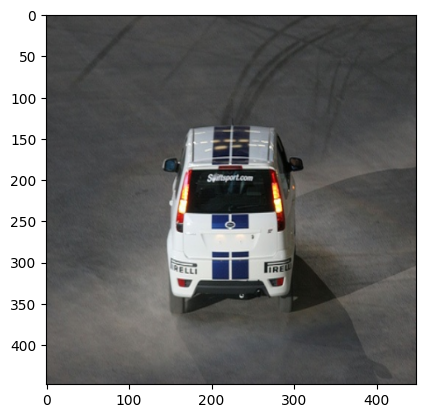

In [ ]:
plt.imshow(temp_img)
plt.show()

In [ ]:
xymin, xymax = yolo_gt(temp_y)
xymin.shape, xymax.shape

(TensorShape([1, 7, 7, 1, 1, 2]), TensorShape([1, 7, 7, 1, 1, 2]))

In [ ]:
xymingt, xymaxgt = xymin[0,:,:,0,0,:], xymax[0,:,:,0,0,:]

xymingt.shape, xymaxgt.shape

(TensorShape([7, 7, 2]), TensorShape([7, 7, 2]))

In [ ]:
# xymingt

In [ ]:
def plot_label(img, xymin, xymax, conf=None):
  im = img.copy()
  h, w = im.shape[:2]

  # plt.imshow(im)

  for i in range(0, 448-int(h/7), int(h/7)):
    plt.axvline(i+int(h/7), color='r')
    plt.axhline(i+int(h/7), color='r')


  for i in range(7):
    for j in range(7):
      xmin = xymin[i][j][0]
      ymin = xymin[i][j][1]

      xmax = xymax[i][j][0]
      ymax = xymax[i][j][1]


      # print('xmin, ymin',xmin, ymin)
      # print('xmax, ymax',xmax, ymax)

      

      # if isinstance(xmin, float):
      # print((int(xmin), int(ymin)), (int(xmax), int(ymax)))

      if conf != None:

        s = conf[i][j]
        
        s = s.numpy()

        if s > 0.1:

          plt.plot(xmin, ymin, marker="o", markersize=5, markeredgecolor="green", markerfacecolor="green")
          plt.plot(xmax, ymax, marker="o", markersize=7, markeredgecolor="blue", markerfacecolor="blue")

          # cv2.rectangle(im, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 15)

          # font
          font = cv2.FONT_HERSHEY_SIMPLEX

          # org
          org = (int(xmin), int(ymin)-20)

          # fontScale
          fontScale = 1

          # Blue color in BGR
          color = (0, 255, 0)

          # Line thickness of 2 px
          thickness = 2

          # Using cv2.putText() method
          image = cv2.putText(im, 
                              str(s), 
                              org, 
                              font,
                              fontScale, 
                              color, 
                              thickness, 
                              cv2.LINE_AA)
          
          cv2.rectangle(im, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)



  plt.imshow(im)
  plt.show()
  # return im

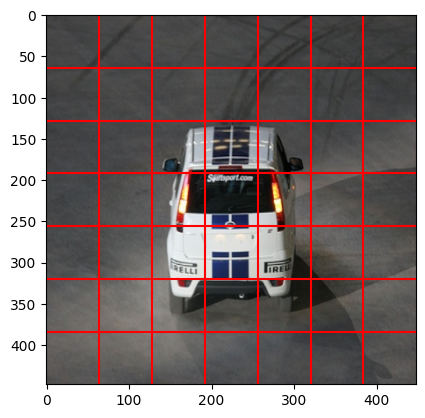

In [ ]:
out = plot_label(temp_img, xymingt, xymaxgt)

In [ ]:
7*7*(20+5+5)

1470

# Predict

In [ ]:
import tensorflow as tf

In [ ]:
input_shape = (448, 448, 3)
inputs = Input(input_shape)
yolo_outputs = model_tiny_yolov1(inputs)

model = Model(inputs=inputs, outputs=yolo_outputs)

In [ ]:
model.load_weights(weight_path)
model.summary()

In [ ]:
def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [ ]:
def yolo_pred(y_pred):

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    trust = K.max(predict_trust, axis=2, keepdims=True)
    best_box_xy_min = K.max(predict_xy_min, axis=3, keepdims=True)
    best_box_xy_max = K.max(predict_xy_max, axis=3, keepdims=True)

    # return predict_xy_min, predict_xy_max, trust
    return best_box_xy_min, best_box_xy_max, trust

In [ ]:
# # serialize model to json
# json_model = model.to_json()
# #save the model architecture to JSON file
# with open('yolov1_architecture.json', 'w') as json_file:
#     json_file.write(json_model)

In [ ]:
# model1 = tf.keras.models.load_model('/content/yolov1_tiny.h5')
# model1

In [ ]:
pred = model.predict(x)
pred.shape

1/1 [==============================] - 0s 120ms/step


(32, 7, 7, 30)

In [ ]:
predy = pred[0]
predy.shape

(7, 7, 30)

In [ ]:
xymin, xymax, trust = yolo_pred(predy)
xymin.shape, xymax.shape, trust.shape

(TensorShape([1, 7, 7, 1, 1, 2]),
 TensorShape([1, 7, 7, 1, 1, 2]),
 TensorShape([7, 7, 1]))

In [ ]:
xymingt, xymaxgt, conf = xymin[0,:,:,0,0,:], xymax[0,:,:,0,0,:], trust[:,:,0]

xymingt.shape, xymaxgt.shape, conf.shape

(TensorShape([7, 7, 2]), TensorShape([7, 7, 2]), TensorShape([7, 7]))

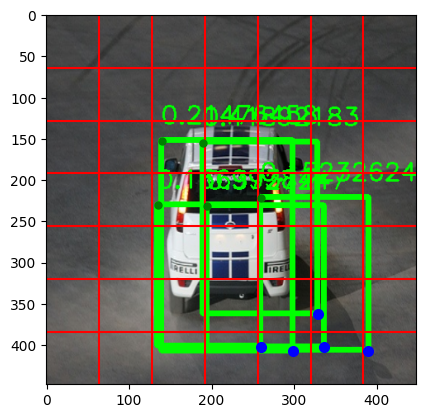

In [ ]:
out = plot_label(temp_img, xymingt, xymaxgt, conf)

# THE END